In [1]:
import importlib

from __init__ import *
from __init__jupyterlab import *
from scipy import sparse
import collections
import itertools
import re
import fbpca
import sys

import snmcseq_utils
importlib.reload(snmcseq_utils)
import CEMBA_run_tsne
import CEMBA_clst_utils
import SCF_utils
importlib.reload(SCF_utils)

import seaborn as sns 
import matplotlib.pyplot as plt

# Configs  

In [2]:
name = 'mop_9mods_v2_corr_190702'
outdir = '/cndd/fangming/CEMBA/data/MOp_all/results'
output_pcX_all = outdir + '/pcX_all_{}.npy'.format(name)
output_cells_all = outdir + '/cells_all_{}.npy'.format(name)
output_clst_and_umap = outdir + '/intg_summary_{}.tsv'.format(name)
output_figures = outdir + '/figures/{}_{{}}.{{}}'.format(name)
# SAVE_KNN_MAT = True
# output_knn_mat = outdir + '/knn_{}_{{}}_from_{{}}.npz'.format(name)

In [8]:
DATA_DIR = '/cndd/fangming/CEMBA/data/MOp_all/organized_neurons_v6'

# fixed dataset configs
sys.path.insert(0, DATA_DIR)
import __init__datasets
importlib.reload(__init__datasets)
from __init__datasets import *

meta_f = os.path.join(DATA_DIR, '{0}_metadata.tsv')
hvftrs_f = os.path.join(DATA_DIR, '{0}_hvfeatures.{1}')
hvftrs_gene = os.path.join(DATA_DIR, '{0}_hvfeatures.gene')
hvftrs_cell = os.path.join(DATA_DIR, '{0}_hvfeatures.cell')

In [9]:
mods_selected = [
    'snmcseq_gene',
    'snatac_gene',
    'smarter_cells',
    'smarter_nuclei',
    '10x_cells', 
    '10x_nuclei', 
    '10x_cells_v3',
    '10x_nuclei_v3',
    '10x_nuclei_v3_Macosko',
    ]

features_selected = ['10x_cells']
# check features
for features_modality in features_selected:
    assert (features_modality in mods_selected)

# within modality
ps = {'mc': 0.9,
      'atac': 0.1,
      'rna': 0.7,
     }
drop_npcs = {'mc': 0,
      'atac': 0,
      'rna': 0,
     }

# across modality
cross_mod_distance_measure = 'correlation' # cca
knn = 20 
relaxation = 3
n_cca = 30

# PCA
npc = 50

# clustering
k = 30
resolutions = [0.8, 1, 2, 4]
# umap
umap_neighbors = 60
min_dist=min_dist = 0.5

## Read in data 

In [10]:
log = snmcseq_utils.create_logger()
logging.info('*')

07/09/2019 03:02:32 PM *


In [11]:
metas = collections.OrderedDict()
for mod in mods_selected:
    metas[mod] = pd.read_csv(meta_f.format(mod), sep="\t").reset_index().set_index(settings[mod].cell_col)
    print(mod, metas[mod].shape)

snmcseq_gene (4936, 38)
snatac_gene (17370, 27)
smarter_cells (6244, 11)
smarter_nuclei (5911, 11)
10x_cells (117688, 12)
10x_nuclei (77842, 12)
10x_cells_v3 (109853, 2)
10x_nuclei_v3 (39537, 2)
10x_nuclei_v3_Macosko (121131, 7)


In [7]:
gxc_hvftrs = collections.OrderedDict()
for mod in mods_selected:
    print(mod)
    ti = time.time()
    
    if settings[mod].mod_category == 'mc':
        f_mat = hvftrs_f.format(mod, 'tsv')
        gxc_hvftrs[mod] = pd.read_csv(f_mat, sep='\t', header=0, index_col=0) 
        gxc_hvftrs[mod].index = SCF_utils.standardize_gene_name(gxc_hvftrs[mod].index)  # standardize gene name 
        print(gxc_hvftrs[mod].shape, time.time()-ti)
        assert np.all(gxc_hvftrs[mod].columns.values == metas[mod].index.values) # make sure cell name is in the sanme order as metas (important if save knn mat)
        continue
        
        
    f_mat = hvftrs_f.format(mod, 'npz')
    f_gene = hvftrs_gene.format(mod)
    f_cell = hvftrs_cell.format(mod)
    _gxc_tmp = snmcseq_utils.load_gc_matrix(f_gene, f_cell, f_mat)
    _gene = _gxc_tmp.gene
    _cell = _gxc_tmp.cell
    _mat = _gxc_tmp.data

    _gene = SCF_utils.standardize_gene_name(_gene)  # standardize gene name  
    ## remove duplicated genes (for now)
    u, c = np.unique(_gene, return_counts=True)
    dup = u[c > 1]
    uniq_bool = np.array([False if gene in dup else True for gene in _gene])
    _gene_selected = _gene[uniq_bool]
    _gene_selected_idx = np.arange(len(_gene))[uniq_bool]
    _gene = _gene_selected
    _mat = _mat.tocsr()[_gene_selected_idx, :]
    ## remove duplicated genes complete
    
    gxc_hvftrs[mod] = GC_matrix(_gene, _cell, _mat)
    assert np.all(gxc_hvftrs[mod].cell == metas[mod].index.values) # make sure cell name is in the sanme order as metas (important if save knn mat)
    print(gxc_hvftrs[mod].data.shape, time.time()-ti)
    

snmcseq_gene
(4830, 4936) 7.093121767044067
smarter_cells
(4338, 6244) 1.9980700016021729
smarter_nuclei
(3955, 5911) 0.8302607536315918


## run SCF

In [8]:
pcX_all, cells_all = SCF_utils.core_scf_routine(mods_selected, features_selected, settings, 
                                                metas, gxc_hvftrs, 
                                                ps, drop_npcs,
                                                cross_mod_distance_measure, knn, relaxation, n_cca,
                                                npc,
                                                output_pcX_all, output_cells_all,
                                                )

Smoothing within modalities...
Time used to build kNN map 0.11535334587097168
Time used to get kNN 0.1983933448791504
snmcseq_gene: 1.5069146156311035
Time used to build kNN map 0.08729171752929688
Time used to get kNN 0.22246241569519043
smarter_cells: 1.9398579597473145
Time used to build kNN map 0.07703256607055664
Time used to get kNN 0.2145683765411377
smarter_nuclei: 1.6465024948120117
Constructing a joint matrix...
Imputing into smarter_cells space...
for smarter_cells cells...
4936 6244 7.009506225585938e-05
40 4980 5.942859888076782
for smarter_cells cells...
for smarter_cells cells...
5911 6244 0.00010371208190917969
7 4947 29.564818859100342
Saved output to: /cndd/fangming/CEMBA/data/MOp_all/results/pcX_all_MOp_neurons_v3_190701-test.npy
Saved output to: /cndd/fangming/CEMBA/data/MOp_all/results/cells_all_MOp_neurons_v3_190701-test.npy


In [9]:
df_summary = SCF_utils.clustering_umap_routine(pcX_all, cells_all, mods_selected, metas,
                                               resolutions, k, 
                                               umap_neighbors, min_dist, 
                                               output_clst_and_umap,
                                              )

resolution r: 1
resolution r: 2
resolution r: 4
resolution r: 8


07/02/2019 02:58:11 PM Running UMAP: 60 n_neighbors, 0.5 min_dist , 2 dim.
Input shape: (17091, 50)
07/02/2019 02:58:52 PM Done with tSNE. running time: 40.09538674354553 seconds.


## All done, making plots after 

- Plotting packages

In [12]:
f = output_clst_and_umap

df_info = pd.read_csv(f, sep="\t", index_col='sample') 
df_info = df_info.rename({
                          'tsne_x': 'tsne_x_joint',
                          'tsne_y': 'tsne_y_joint',
                         }, axis=1)
df_info['modality_name'] = df_info['modality'].apply(lambda mod: settings[mod].name)

# add cluster, annot info
df_info['cluster'] = ''
df_info['annot'] = ''
for mod in mods_selected:
    _cells = metas[mod].index.values
    df_info.loc[_cells, 'cluster'] = metas[mod].loc[_cells, settings[mod].cluster_col]
    df_info.loc[_cells, 'annot'] = metas[mod].loc[_cells, settings[mod].annot_col]

print(df_info.shape)
df_info.head()

(500738, 10)


cluster_joint_r0.8  cluster_joint_r1  \
sample                                                                       
3C1.AGCGATAGAAGAGGCAAAGGCTATATAGAGGC                   6                 2   
3C1.AGCGATAGAAGAGGCAAAGGCTATCCTATCCT                   3                 4   
3C1.AGCGATAGAAGAGGCAACTGCATAAGGCGAAG                   2                 6   
3C1.AGCGATAGAAGAGGCAATCTGAGTATAGAGGC                   3                 5   
3C1.AGCGATAGAAGAGGCACGTCTAATCCTATCCT                   6                 7   

                                      cluster_joint_r2  cluster_joint_r4  \
sample                                                                     
3C1.AGCGATAGAAGAGGCAAAGGCTATATAGAGGC                14                 2   
3C1.AGCGATAGAAGAGGCAAAGGCTATCCTATCCT                 6                33   
3C1.AGCGATAGAAGAGGCAACTGCATAAGGCGAAG                 7                27   
3C1.AGCGATAGAAGAGGCAATCTGAGTATAGAGGC                 6                33   
3C1.AGCGATAGAAGAGGCACGTCTAATCCTATCCT                31                 2   

                                      tsne_x_joint  tsne_y_joint     modality  \
sample                                                                          
3C1.AGCGATAGAAGAGGCAAAGGCTATATAGAGGC      0.853421    -11.758800  snatac_gene   
3C1.AGCGATAGAAGAGGCAAAGGCTATCCTATCCT      1.093704     11.677540  snatac_gene   
3C1.AGCGATAGAAGAGGCAACTGCATAAGGCGAAG      4.784478     -5.157915  snatac_gene   
3C1.AGCGATAGAAGAGGCAATCTGAGTATAGAGGC      1.958046     13.502572  snatac_gene   
3C1.AGCGATAGAAGAGGCACGTCTAATCCTATCCT      2.123386    -10.900025  snatac_gene   

                                     modality_name  cluster annot  
sample                                                             
3C1.AGCGATAGAAGAGGCAAAGGCTATATAGAGGC      ATAC Seq        6     6  
3C1.AGCGATAGAAGAGGCAAAGGCTATCCTATCCT      ATAC Seq       20    20  
3C1.AGCGATAGAAGAGGCAACTGCATAAGGCGAAG      ATAC Seq       19    19  
3C1.AGCGATAGAAGAGGCAATCTGAGTATAGAGGC      ATAC Seq       20    20  
3C1.AGCGATAGAAGAGGCACGTCTAATCCTATCCT      ATAC Seq        7     7

In [13]:
# clean up annotation
df_info['annot'] = df_info['annot'].str.replace('_Glutamatergic', '')
df_info['annot'] = df_info['annot'].str.replace('_GABAergic', '')
df_info['annot'] = df_info['annot'].fillna(df_info['cluster'])

In [14]:
set_matplotlib_formats('retina')

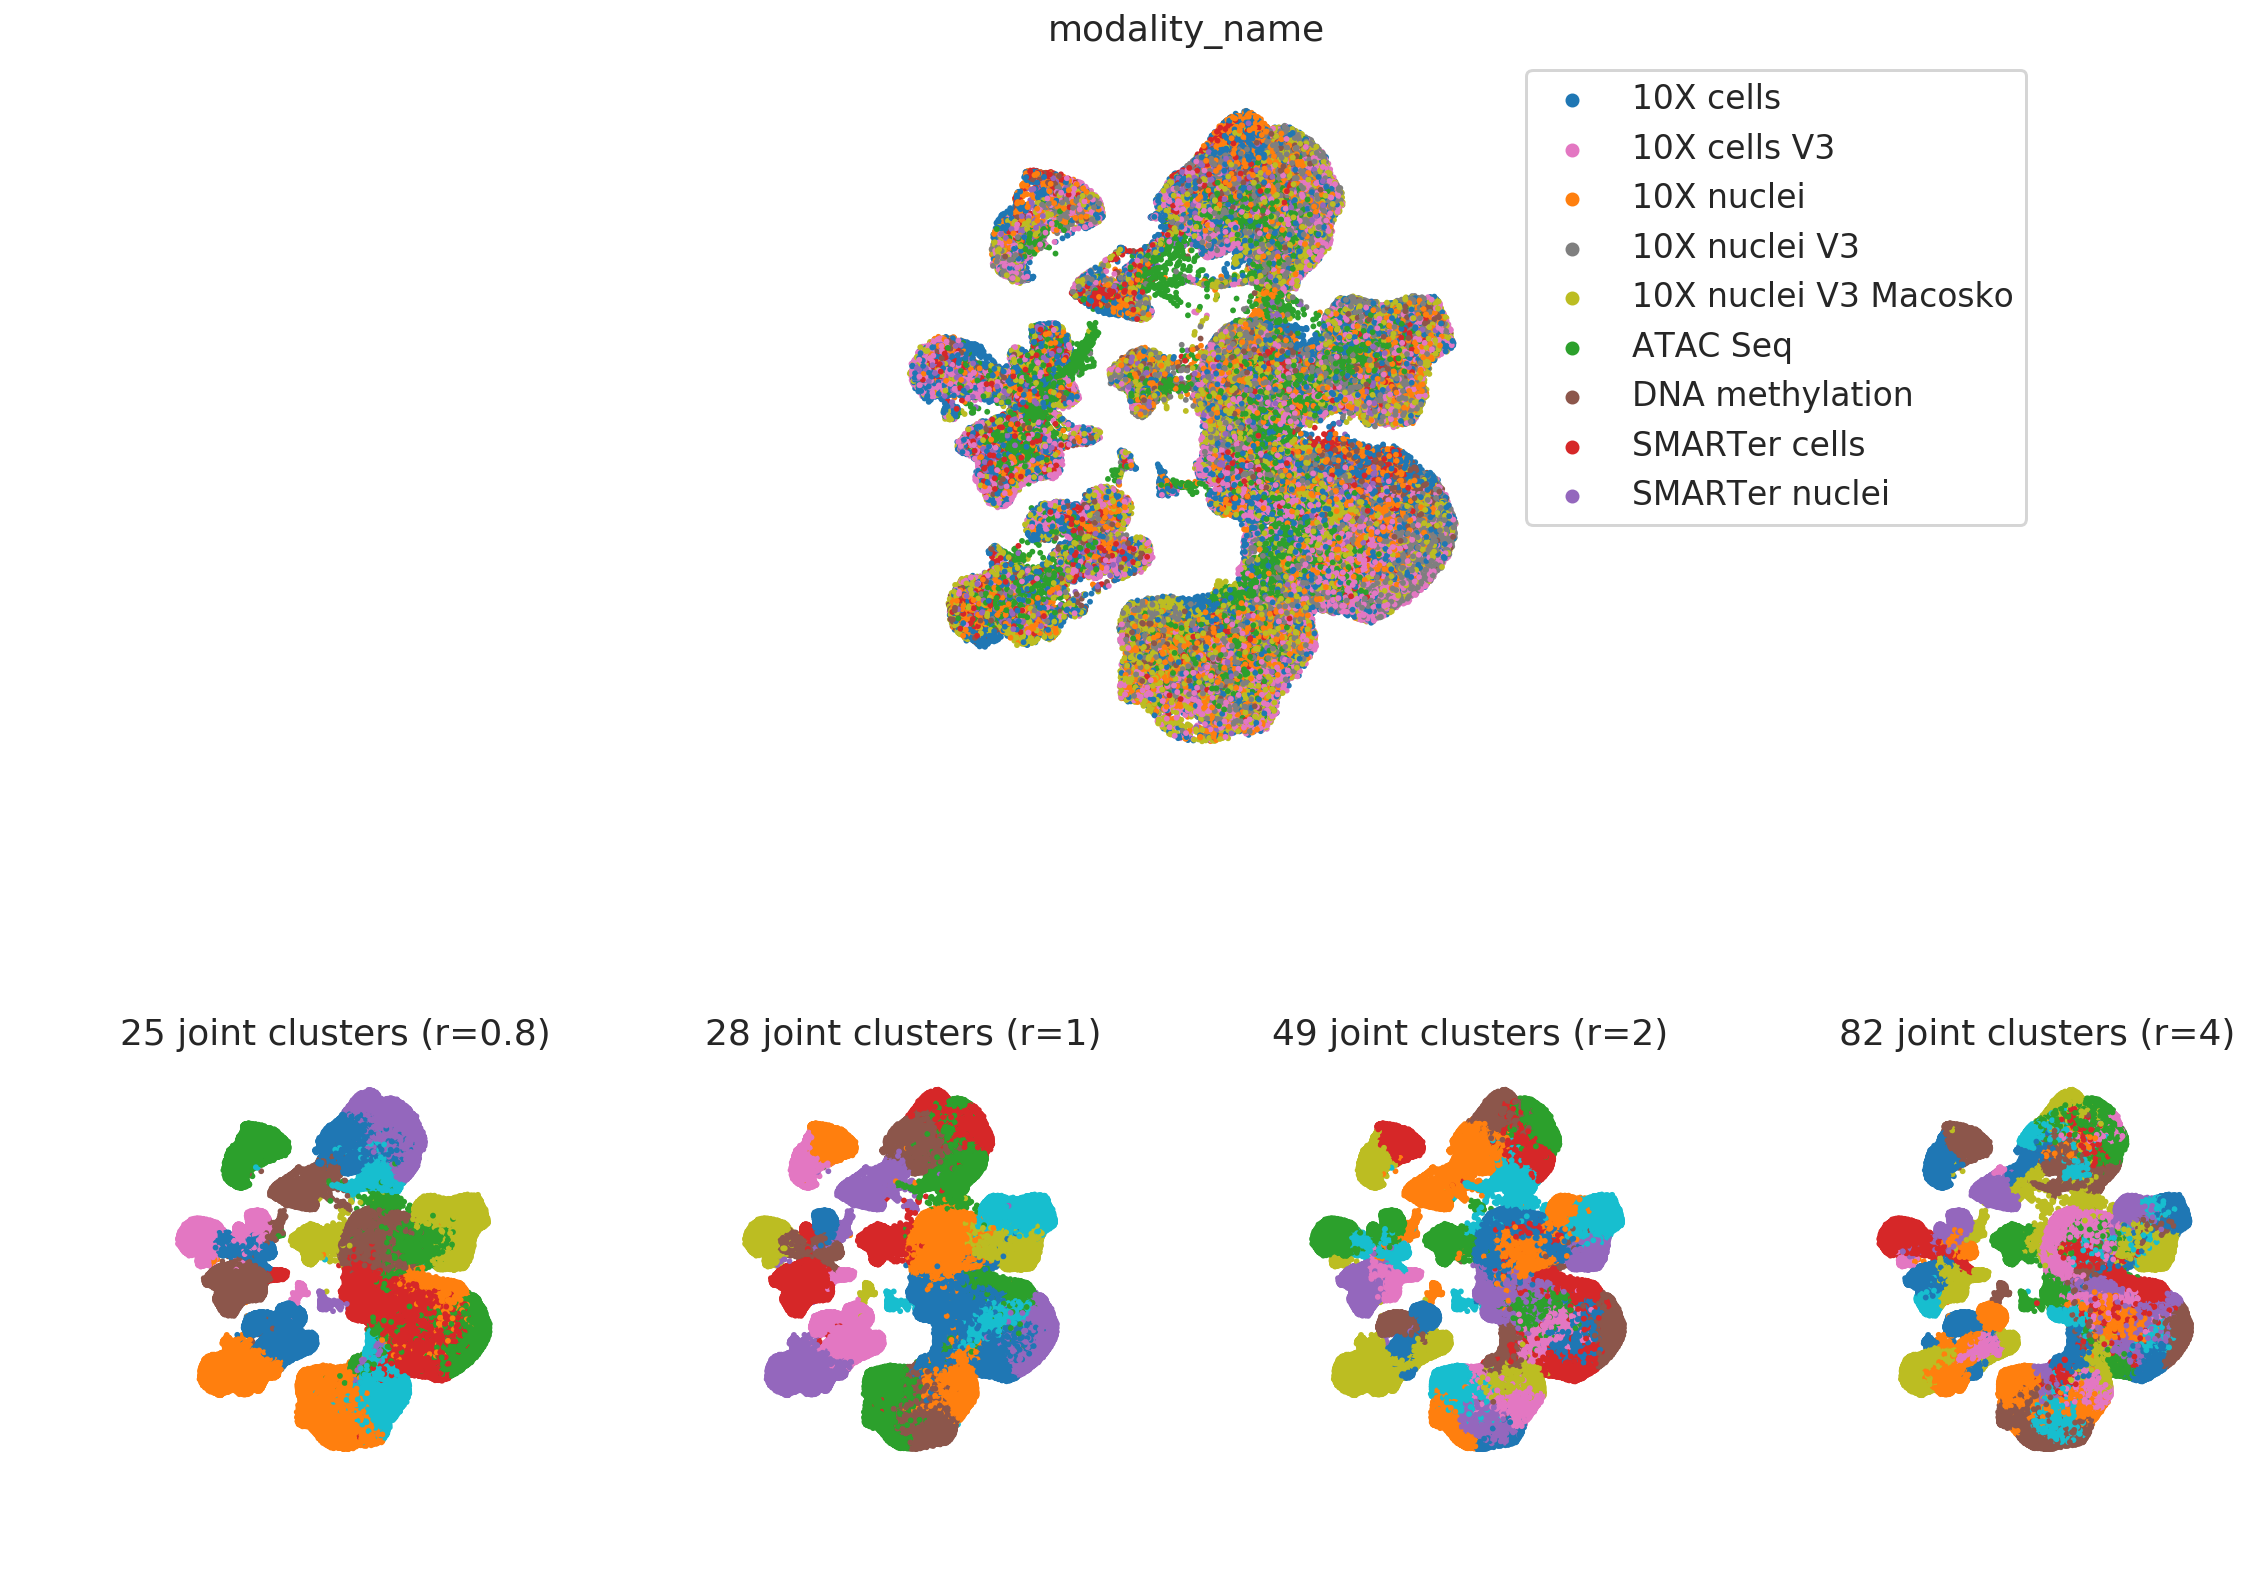

In [15]:
from matplotlib.gridspec import GridSpec

sample_n = min(len(df_info), 20000)
n_resolutions = len(resolutions)
with sns.plotting_context('talk'):
    fig = plt.figure(figsize=(8*2,6*2))
    gs = GridSpec(2, n_resolutions)
    
    ax = fig.add_subplot(gs[0, :])
    kw_colors = {settings[mod].name: settings[mod].color for mod in mods_selected}
    tx, ty, tc = 'tsne_x_joint', 'tsne_y_joint', 'modality_name'
    legend_kws = {'bbox_to_anchor': (1, 1), 'loc': 'upper left'}
    snmcseq_utils.plot_tsne_labels_ax(df_info, ax, tx, ty, tc, 
                                      legend_kws=legend_kws,
                                      kw_colors=kw_colors,
                                      sample_n=sample_n,
                                      legend_size=30,
                                      rasterized=True,
                                      s=2,
                                     )
    ax.set_aspect('equal')
    ax.axis('off')
    
    layouts = [(1, i) for i in range(n_resolutions)]
    for resolution, layout in zip(resolutions, layouts):
        ax = fig.add_subplot(gs[layout[0], layout[1]])
        tx, ty, tc = 'tsne_x_joint', 'tsne_y_joint', 'cluster_joint_r{}'.format(resolution)
        snmcseq_utils.plot_tsne_labels_ax(df_info, ax, tx, ty, tc, 
                                          legend_mode=-1,
                                          sample_n=sample_n,
                                          rasterized=True,
                                          s=2,
                                         )
        ax.set_aspect('equal')
        ax.axis('off')
        ax.set_title('{} joint clusters (r={})'.format(len(df_info[tc].unique()), resolution))
    
    fig.tight_layout()
    fig.savefig(output_figures.format(1, 'pdf'), bbox_inches='tight', dpi=300)
    plt.show()
    


In [16]:
centroids = {}
_x = (df_info[['tsne_x_joint', 'tsne_y_joint', 'annot', 'modality']]
             .groupby(['modality', 'annot']).median())


for mod in mods_selected:
    centroids[mod] = _x.loc[mod, :]
centroids['joint'] = (df_info[['tsne_x_joint', 'tsne_y_joint', 'cluster_joint_r1']]
             .groupby(['cluster_joint_r1']).median())

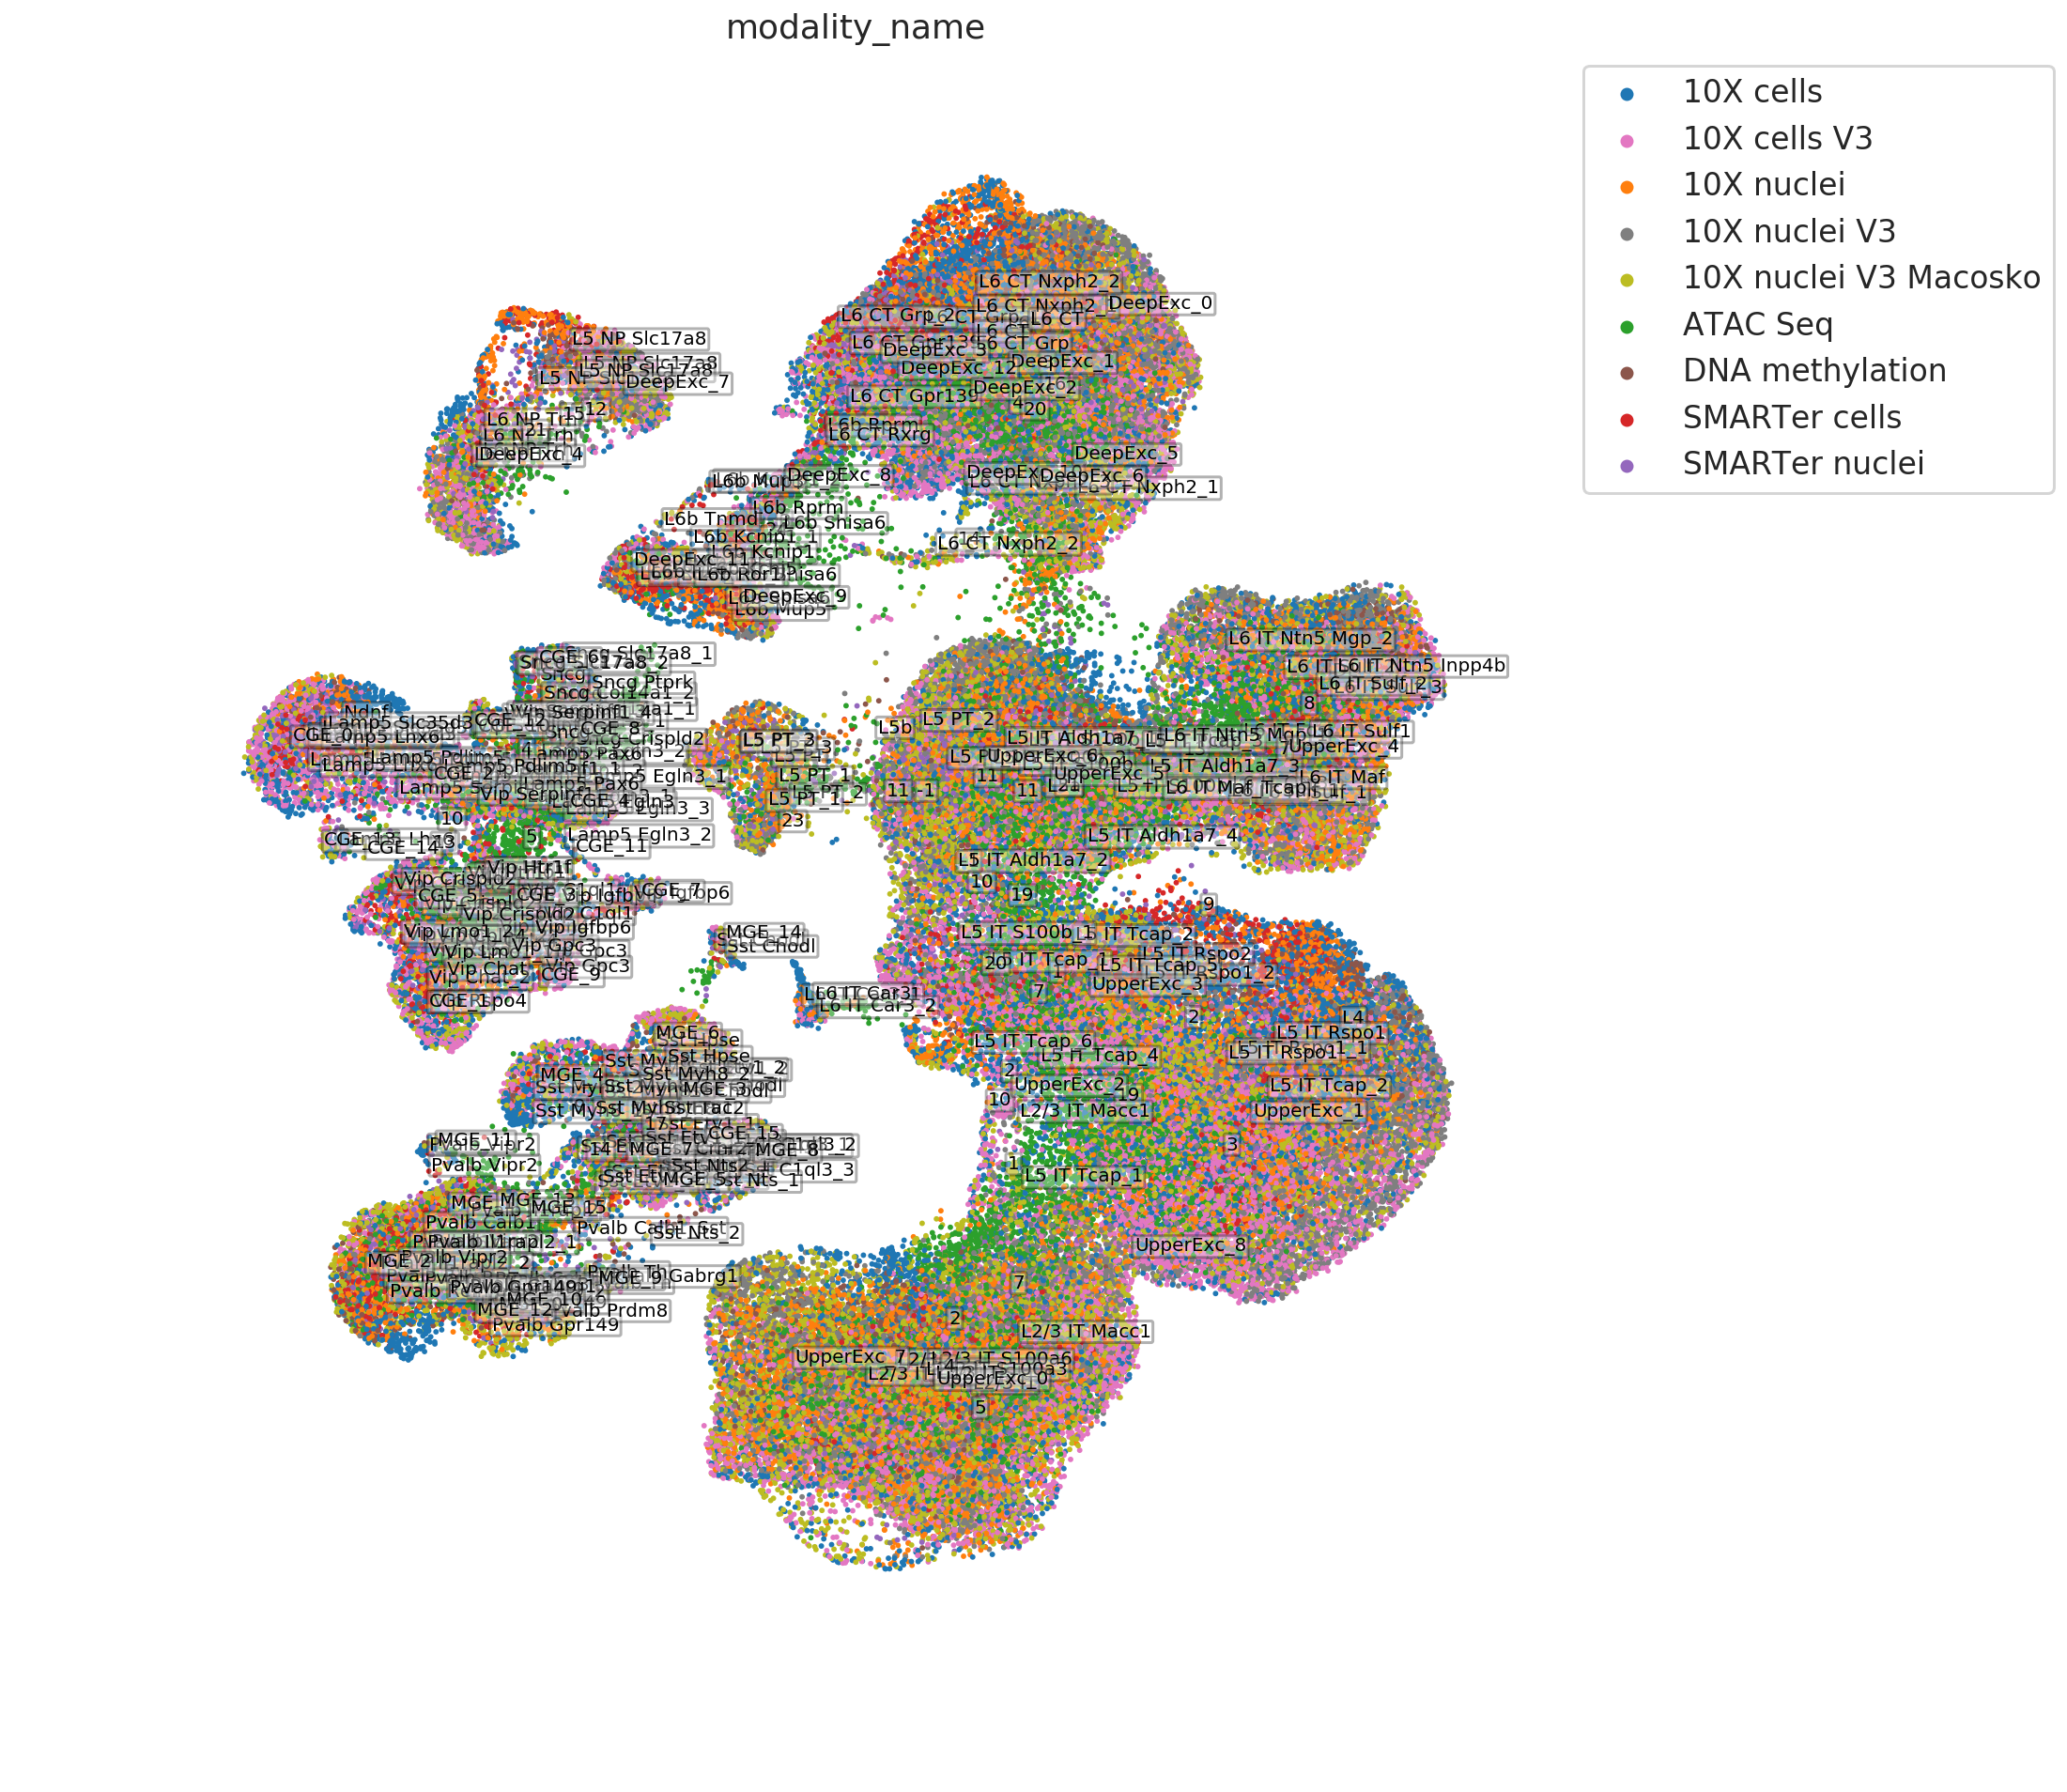

In [17]:
with sns.plotting_context('talk'):
    fig, ax = plt.subplots(1, 1, figsize=(16*1,16*1))
    kw_colors = {settings[mod].name: settings[mod].color for mod in mods_selected}
    tx, ty, tc = 'tsne_x_joint', 'tsne_y_joint', 'modality_name'
    legend_kws = {'bbox_to_anchor': (1, 1), 'loc': 'upper left'}
    snmcseq_utils.plot_tsne_labels_ax(df_info, ax, tx, ty, tc, 
                                      legend_kws=legend_kws,
                                      sample_n=sample_n,
                                      legend_size=30,
                                      rasterized=True,
                                      kw_colors=kw_colors,
                                      s=2,
                                     )
    ax.set_aspect('equal')
    ax.axis('off')
    
    # add labels
    for mod in mods_selected:
        for clst, centroid in centroids[mod].iterrows():
            facecolor='white'
            ax.text(centroid.values[0], 
                    centroid.values[1], 
                    clst,
                    color='black', 
                    bbox=dict(facecolor=facecolor, alpha=0.3, edgecolor='black', boxstyle='round,pad=0.1'),
                    fontsize=10,
                   )
    
    fig.savefig(output_figures.format(2, 'pdf'), bbox_inches='tight', dpi=300)
    plt.show()
    

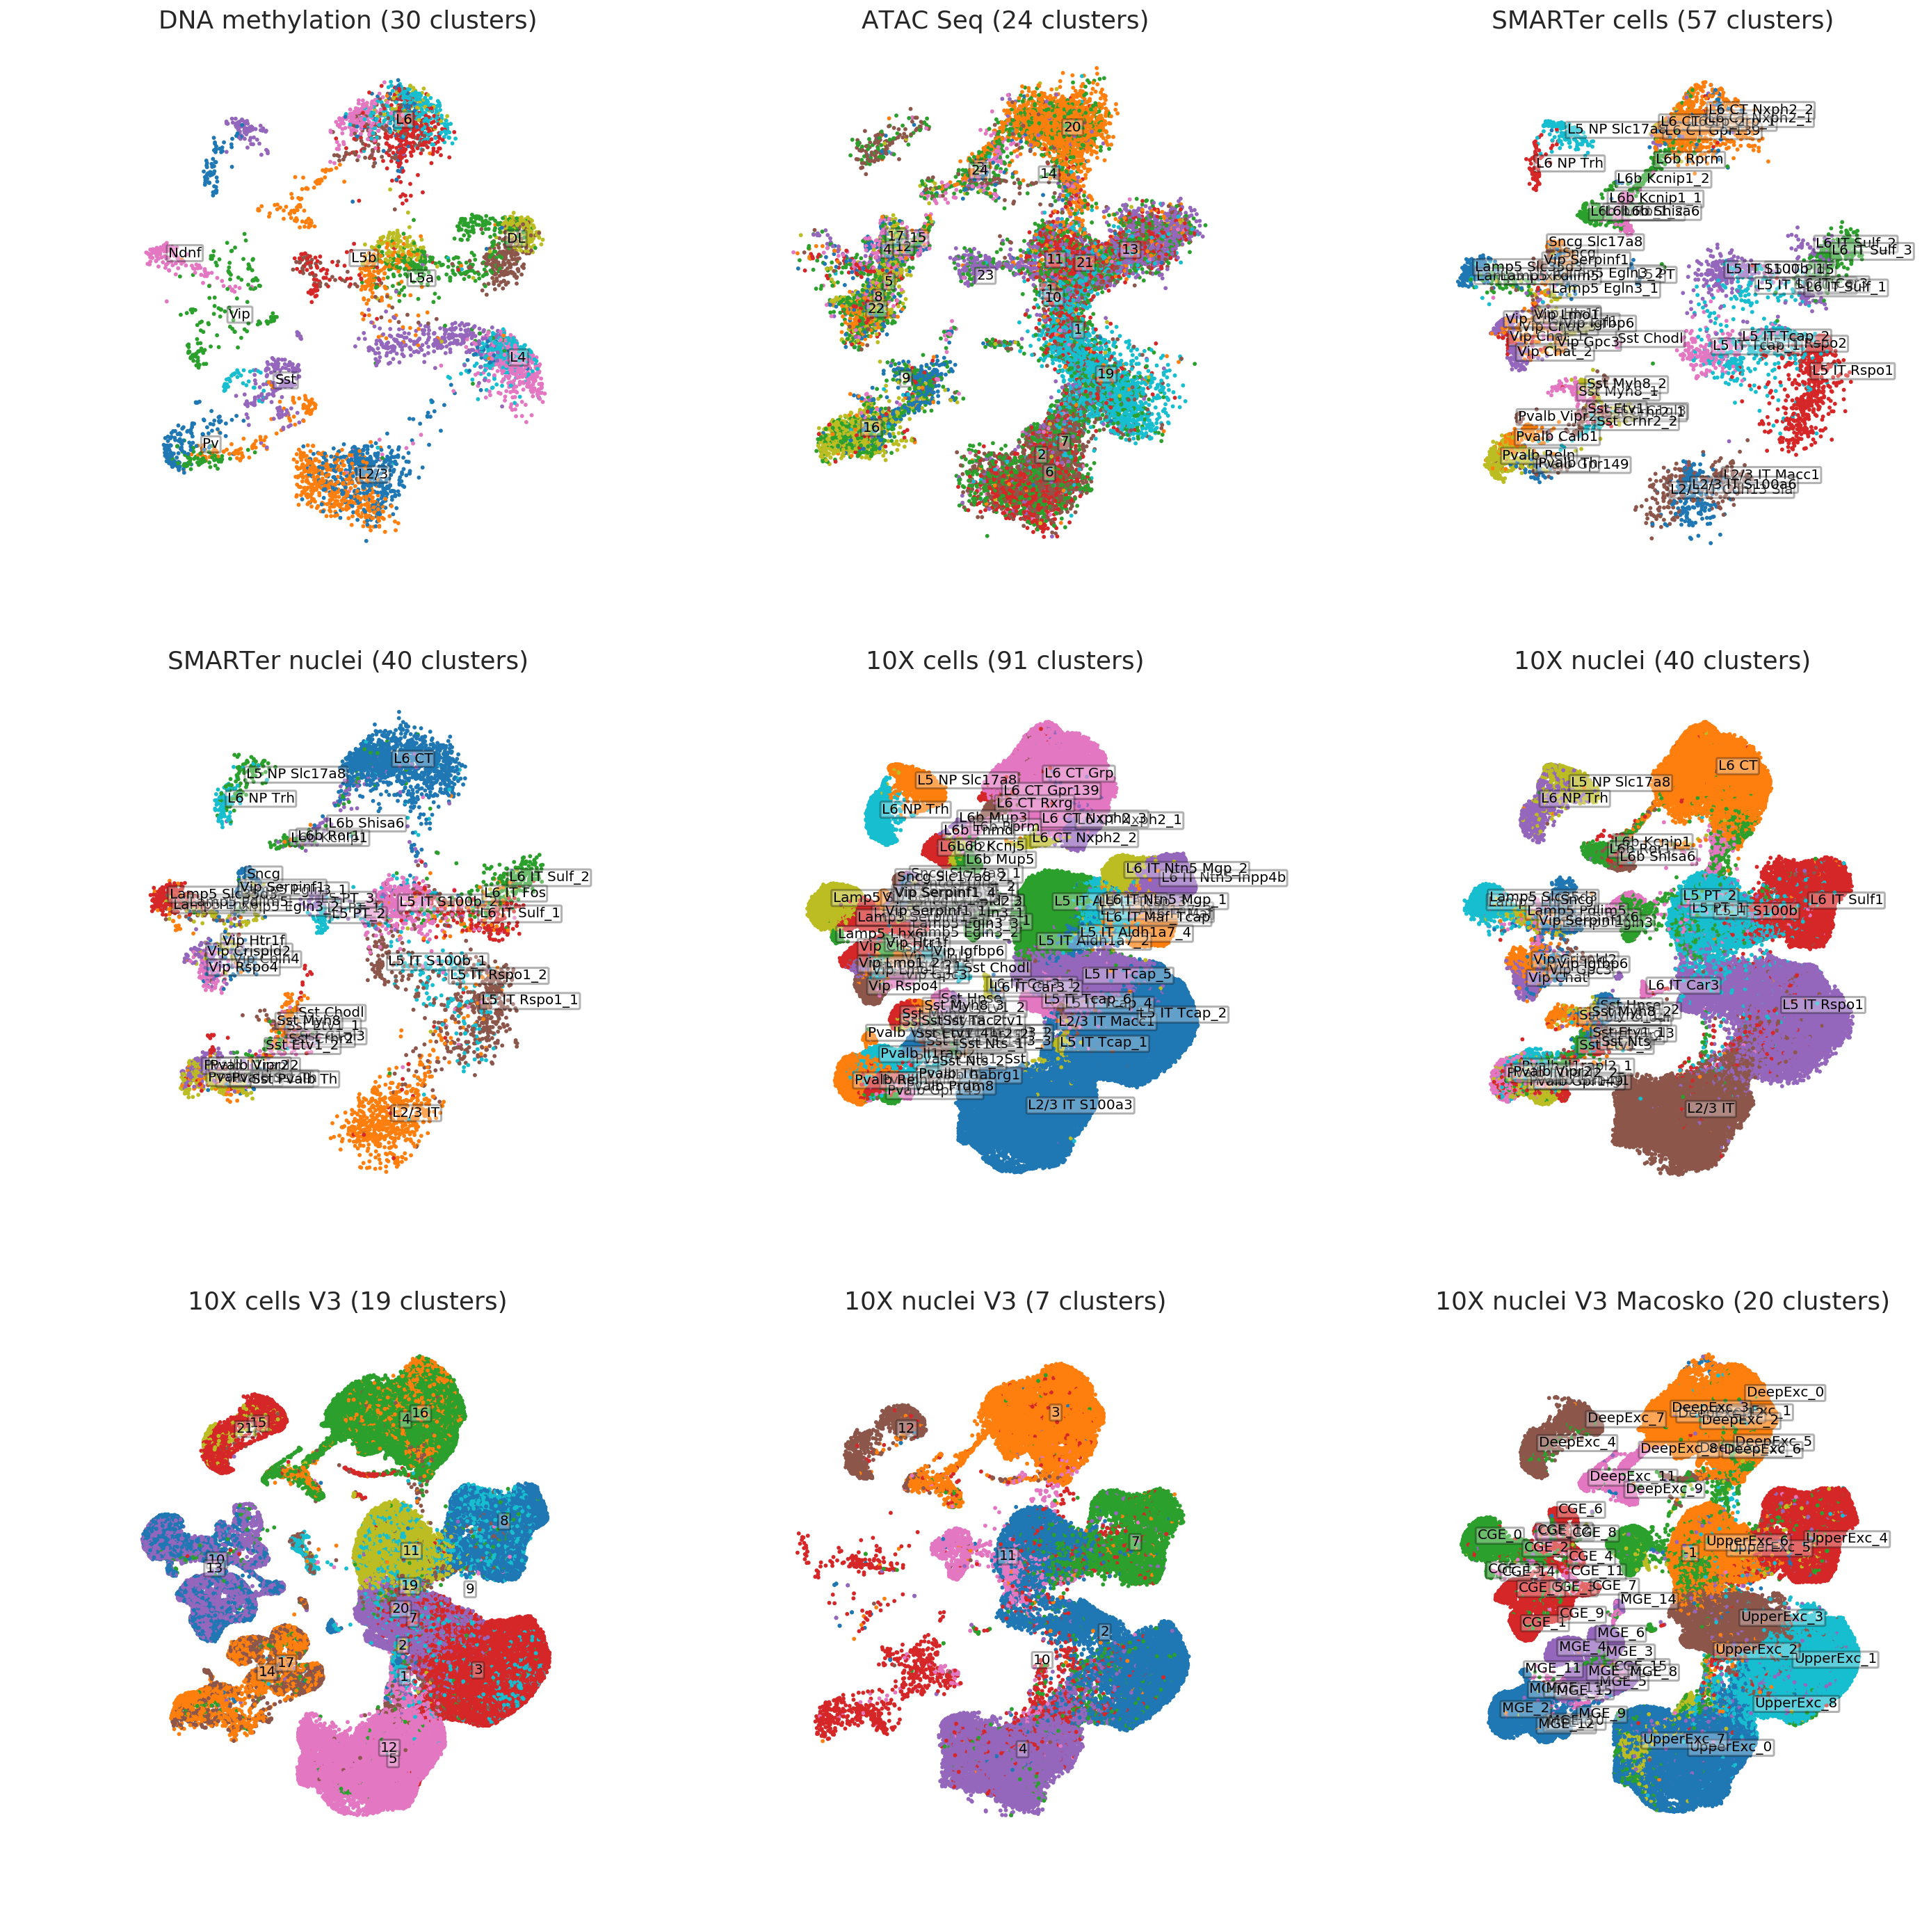

In [18]:
with sns.plotting_context('talk'):
    n = len(mods_selected)
    nx = 3
    ny = int((n+nx-1)/nx)
    fig, axs = plt.subplots(ny, nx, figsize=(8*nx,8*ny))
    axs = axs.flatten()
    kw_colors = {mod: settings[mod].color for mod in mods_selected}
    tx, ty, tc = 'tsne_x_joint', 'tsne_y_joint', 'cluster'
#     legend_kws = {'bbox_to_anchor': (1, 1), 'loc': 'upper left'}
    
    for ax, mod in zip(axs, mods_selected):
        snmcseq_utils.plot_tsne_labels_ax(df_info[df_info['modality']==mod], ax, tx, ty, tc, 
#                                           legend_kws=legend_kws,
                                          sample_n=sample_n,
                                          legend_mode=-1,
                                          rasterized=True,
#                                           kw_colors=kw_colors,
                                          s=2,
                                         )
        ax.set_title('{} ({} clusters)'.format(settings[mod].name, len(df_info.loc[df_info['modality']==mod, tc].unique())))
                                          
        for clst, centroid in centroids[mod].iterrows():
            facecolor='white'
            ax.text(centroid.values[0], 
                    centroid.values[1], 
                    clst,
                    color='black', 
                    bbox=dict(facecolor=facecolor, alpha=0.3, edgecolor='black', boxstyle='round,pad=0.1'),
                    fontsize=10,
                   )
        ax.set_aspect('equal')
        ax.axis('off')
    for ax in axs[n:]:
        ax.axis('off')
        
    
    fig.savefig(output_figures.format(3, 'pdf'), bbox_inches='tight', dpi=300)
    plt.show()
    

In [19]:
# Confusion matrix
# histograms
hist = df_info.groupby(['cluster_joint_r1', 'modality']).size().unstack().fillna(0).astype(int)
hist_mod = hist.sum(axis=0)
hist_clst = hist.sum(axis=1)

hist_frac = hist.divide(hist_clst, axis=0)
hist_exp = pd.DataFrame(np.outer(hist_clst/hist_clst.sum(), hist_mod), 
             index=hist_clst.index, columns=hist_mod.index.values)
hist_enrich = (hist+1)/(hist_exp+1)
hist_enrich.head()

modality          10x_cells  10x_cells_v3  10x_nuclei  10x_nuclei_v3  \
cluster_joint_r1                                                       
1                  0.873476      0.740973    1.048669       1.192190   
2                  0.600007      0.907455    1.487544       1.156520   
3                  1.244214      1.372860    0.676653       0.683999   
4                  1.350136      1.053220    0.586276       1.052499   
5                  1.010969      0.861321    0.901592       1.567896   

modality          10x_nuclei_v3_Macosko  smarter_cells  smarter_nuclei  \
cluster_joint_r1                                                         
1                              1.107494       0.632356        1.240943   
2                              1.135848       0.625056        0.916022   
3                              0.850040       0.698666        0.325840   
4                              0.793322       1.432554        1.705627   
5                              1.042023       0.081967        0.539804   

modality          snatac_gene  snmcseq_gene  
cluster_joint_r1                             
1                    2.152090      0.937636  
2                    0.934331      1.113803  
3                    0.698200      0.476051  
4                    1.060470      1.032738  
5                    1.195159      0.783251

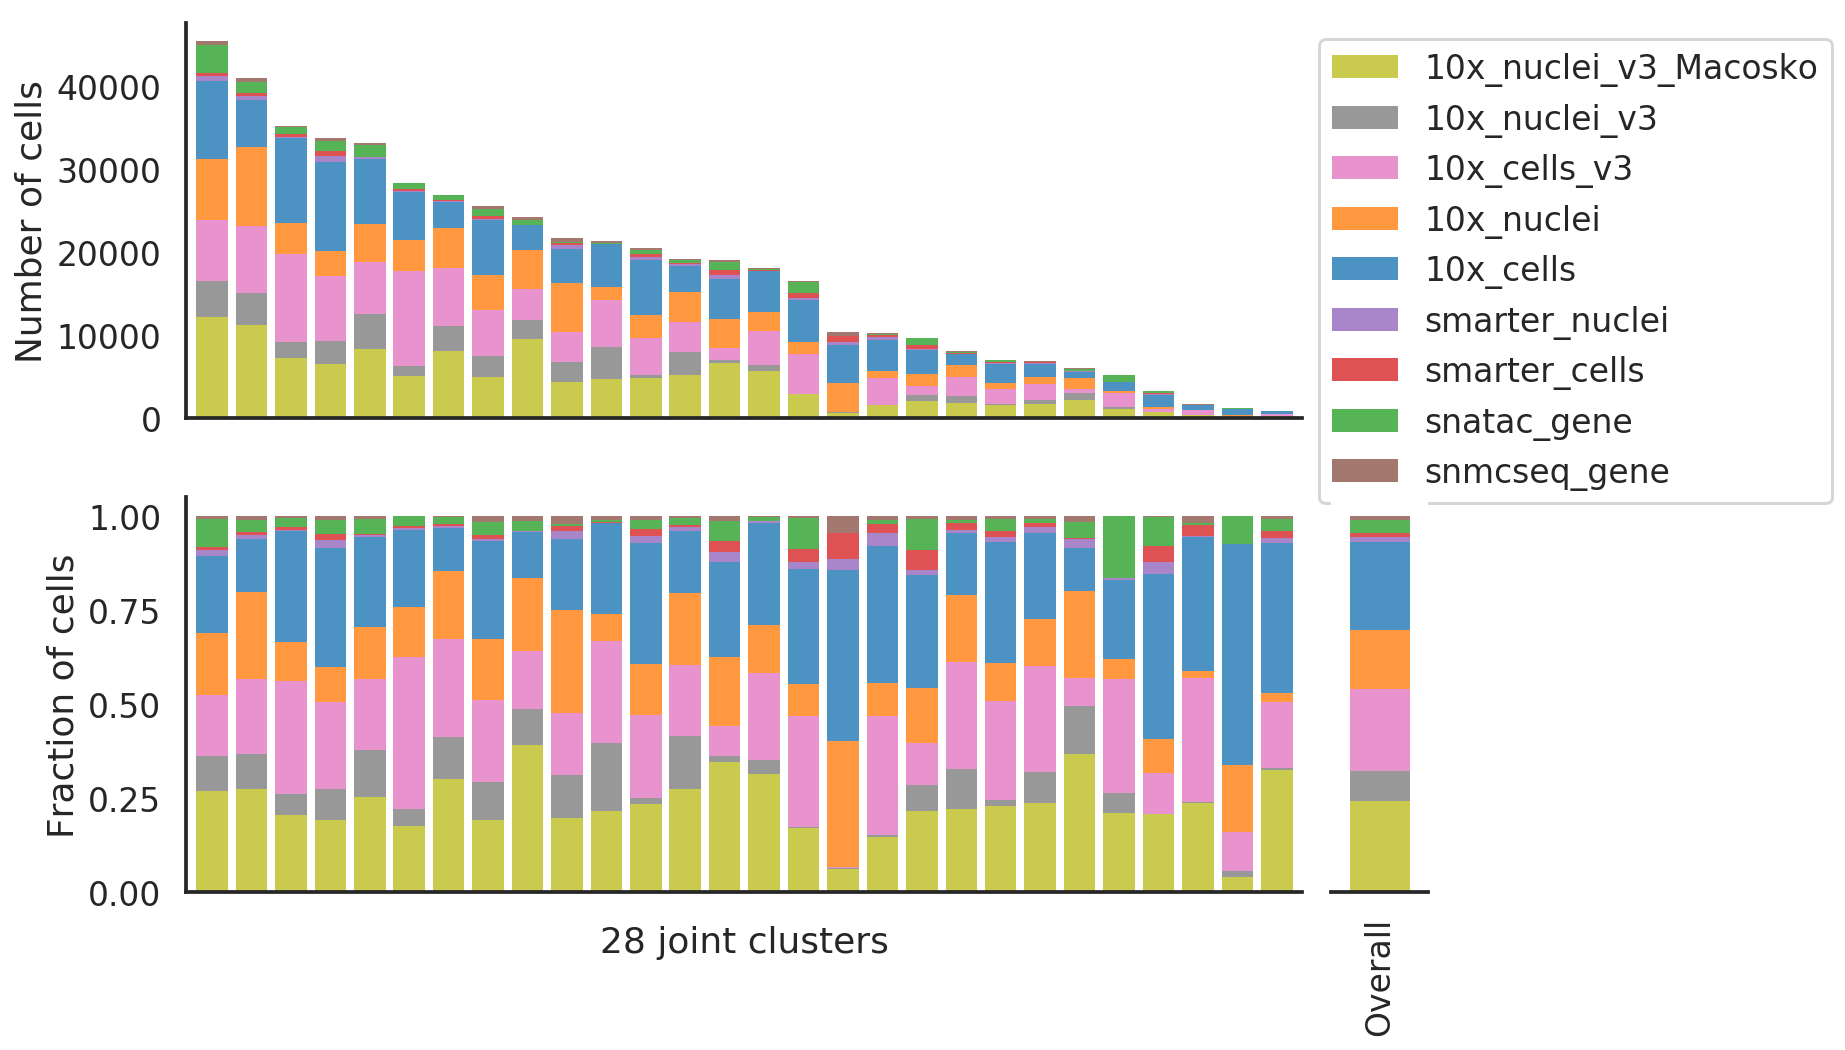

In [20]:
mod_colors = collections.OrderedDict({mod: settings[mod].color for mod in mods_selected})
with sns.plotting_context('talk'), sns.axes_style('white', {"patch.edgecolor": "black", 'patch.force_edgecolor': False,}):
    # histograms
    fig, axs = plt.subplots(2, 1, figsize=(10,4*2))
    ax = axs[0]
    hist[mods_selected[::-1]].plot.bar(stacked=True, width=0.8, alpha=0.8, ax=ax, 
                  color=[val for key, val in mod_colors.items()][::-1], # this controls mod_colors
                 )
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.legend(bbox_to_anchor=(1, 1))
    ax.set_ylabel('Number of cells')
    ax.set_xlabel('')
    ax.set_xticklabels([])
    

    ax = axs[1]
    hist_frac[mods_selected[::-1]].plot.bar(stacked=True, width=0.8, alpha=0.8, ax=ax, legend=False, 
                  color=[val for key, val in mod_colors.items()][::-1], # this controls mod_colors
                 )
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_ylabel('Fraction of cells')
    ax.set_xlabel('{} joint clusters'.format(len(hist)))
    ax.set_xticklabels([])
    
#     ax = fig.add_axes([.95, .5, .05, .4])
    left_x, left_y, width, height = ax.get_position().bounds
    ax = fig.add_axes((left_x+width+0.2*(1-(left_x+width)), left_y, 0.3*(1-width), height))
    ((hist_mod/hist_mod.sum()).loc[mods_selected[::-1]].to_frame().T.rename({0: 'Overall'}, axis=0)
                      .plot.bar(stacked=True, width=0.8, alpha=0.8, ax=ax, legend=False, 
                      color=[val for key, val in mod_colors.items()][::-1]) # this controls mod_colors
    )
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_ylabel('')
    ax.set_yticklabels([])
    
#     fig.tight_layout()
    fig.savefig(output_figures.format(4, 'pdf'), bbox_inches='tight')
    plt.show()

/cndd/fangming/venvs/conda_dobro/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


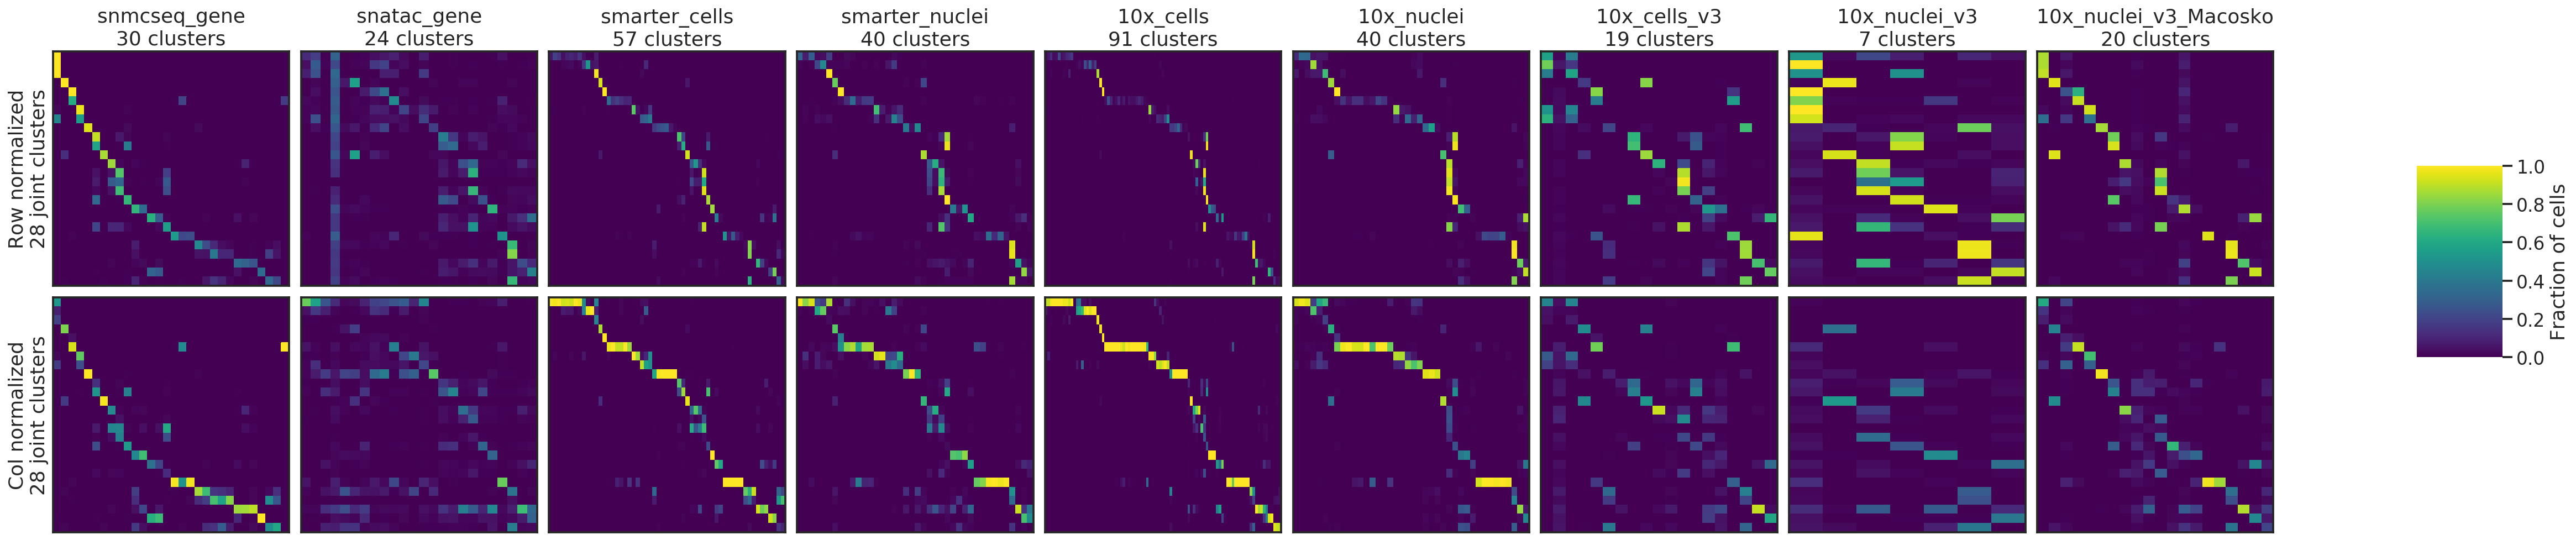

In [21]:
# confusion matrix

nx = len(mods_selected)
ny = 2
heatmap_kws = {
    'xticklabels': False, 
    'yticklabels': False,
    'vmin': 0, 
    'vmax': 1,
    'cmap': 'viridis',
}

cbar_kws = {
    'orientation': 'vertical', 
    'label': 'Fraction of cells',
}

with sns.plotting_context('talk'), sns.axes_style('white', {'patch.edgecolor': 'black'}):
    fig, axs = plt.subplots(ny, nx, figsize=(4*nx, 4*ny))
    axs = axs.T
    cbar_ax = fig.add_axes([0.95, 0.4, 0.03, 0.3])
    njoint_clusters = len(df_info['cluster_joint_r1'].unique())
    for i, (mod, ax) in enumerate(zip(mods_selected, axs)):
        conf_mat = pd.crosstab(df_info.loc[df_info['modality']==mod, 'cluster'], 
                               df_info.loc[df_info['modality']==mod, 'cluster_joint_r1'],
                              )
        # normalize each joint cluster
        conf_mat_njoint = conf_mat.divide(conf_mat.sum(axis=0), axis=1)
        # normalize each orig cluster
        conf_mat_norig = conf_mat.divide(conf_mat.sum(axis=1), axis=0)

        # plot normalized by joint 
        if i == 0:
            # order both row and col
            _X = conf_mat_njoint
            _rX, ri, rc = snmcseq_utils.diag_matrix(_X.values, _X.index.values, _X.columns.values, threshold=0.3)
            _rX = pd.DataFrame(_rX, index=ri, columns=rc)
            g = sns.heatmap(_rX.T, 
                        cbar=True,
                        cbar_kws=cbar_kws,
                        cbar_ax=cbar_ax,
                        ax=ax[0],
                        **heatmap_kws,
                       )
            g.axes.set_title('{}\n{} clusters'.format(mod, _rX.shape[0]))
            g.axes.set_ylabel('Row normalized\n{} joint clusters'.format(njoint_clusters))
            for _, spine in g.axes.spines.items():
                spine.set_visible(True)

            order_joint = _rX.columns.values # Will be fixed for all integrated clusters 
            order_orig = _rX.index.values # Will be fixed for the mod clusters  
        else:
            # order just row (orig)
            _X = conf_mat_njoint.loc[:, order_joint].fillna(0)
            _rX, ri, rc = snmcseq_utils.diag_matrix_rows(_X.values, _X.index.values, _X.columns.values)
            _rX = pd.DataFrame(_rX, index=ri, columns=rc)
            g = sns.heatmap(_rX.T, 
                        cbar=False,
                        ax=ax[0],
                        **heatmap_kws,
                       )
            g.axes.set_title('{}\n{} clusters'.format(mod, _rX.shape[0]))
            g.axes.set_ylabel('')
            for _, spine in g.axes.spines.items():
                spine.set_visible(True)

            order_orig = _rX.index.values # Will be fixed for the mod clusters  

        # plot normalized by orig (according to the axis of normalized by joint) 
        _X = conf_mat_norig.loc[order_orig, order_joint].fillna(0)
        g = sns.heatmap(_X.T, 
                    cbar=False,
                    ax=ax[1],
                    **heatmap_kws,
                   )
        for _, spine in g.axes.spines.items():
            spine.set_visible(True)
        if i == 0:
            g.axes.set_xlabel('')
            g.axes.set_ylabel('Col normalized\n{} joint clusters'.format(njoint_clusters))
        else:
            g.axes.set_xlabel('')
            g.axes.set_ylabel('')

        for _, spine in g.axes.spines.items():
            spine.set_visible(True)

    plt.subplots_adjust(hspace=0.05, wspace=0.05)
    fig.savefig(output_figures.format(5, 'pdf'), bbox_inches='tight')
    plt.show()